# xarray-enabled implementations of parcel functions

[MetPy](https://unidata.github.io/MetPy/latest/index.html) contains functions to calculate properties of lifted air parcels, but these functions work only on 1-dimensional arrays. Using a loop to apply these functions over every pixel in a large data set is slow. This package contains xarray-enabled implementations of the metpy parcel functions; this notebook shows results of testing the xarray implementations.

In [1]:
import xarray
import numpy as np
import metpy
import metpy.plots
import matplotlib.pyplot as plt
import modules.parcel_functions as parcel
import modules.parcel_test as parcel_test
import modules.unit_tests as tests
from metpy.units import units
from importlib import reload

# Settings

In [2]:
plt.rcParams['figure.figsize'] = (16,5)           # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 14                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

# Test data

The test data is a subset from the [Aus400](http://climate-cms.wikis.unsw.edu.au/Aus400) simulations (released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/)), containing pressure/temperature/specific humidity at 90 vertical layers for ~10k points.

In [3]:
dat = xarray.open_dataset('test_data.nc')

# A lookup table for moist lapse rates

The calculation of moist lapse rates is usually iterative. MetPy's `moist_lapse` function uses the SciPy function `odeint`, which is difficult to run in a vectorised format. I have provided a function `moist_lapse_analytical` which attempts to do the iterative calcultion, but it remains slow. To get around this bottleneck, the xarray implementation of `moist_lapse` uses lookup tables of moist adiabats which can be quickly returned and offer an acceptable level of accuracy. The lookup tables are generated by the function `moist_adiabat_tables`. Two lookup tables are returned; one that contains all the adiabats generated, the other that contains an index of which adiabat passes through given combinations of pressure/temperature. The lookup tables are cached on disk for fast access.

In [4]:
moist_adiabat_lookup, moist_adiabats = parcel.moist_adiabat_tables()

The index lookup table (`moist_adiabat_lookup` here) contains a grid of pressure/temperature combinations and identifies the index of the adiabat that passes through those combinations.

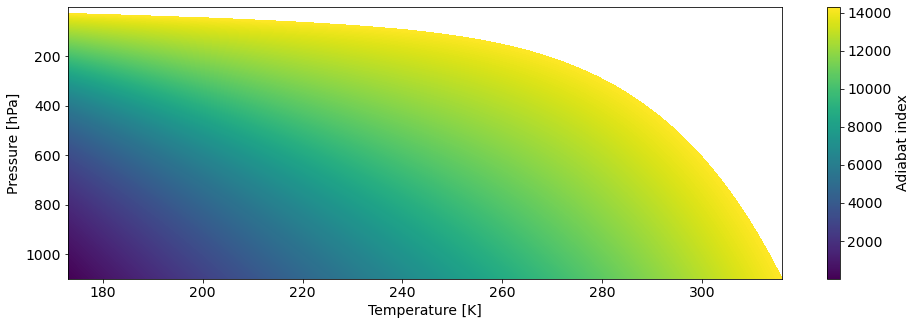

In [5]:
moist_adiabat_lookup.adiabat.plot(y='pressure', yincrease=False, cbar_kwargs={'label': 'Adiabat index'})
plt.show()

Interpolation of the adiabats across the discrete pressure/temperature fields means that pressure/temperature combinations which do not have any associated adiabat (yellow in the plot below) are limited to areas outside reasonable temperature ranges.

In [ ]:
np.isnan(moist_adiabat_lookup.adiabat).plot(y='pressure', yincrease=False,
                                            cbar_kwargs={'label': 'Adiabat missing'})
plt.show()

The following plot shows output from the xarray lookup table implementation and the metpy implementation for a starting parcel at 1000 hPa and a variety of starting parcel temperatures. The adiabats are indistinguishable on the Skew T plot yet there are small differences introduced by the lookup table approach; the maximum difference for these adiabats is reported below.

In [ ]:
skew = metpy.plots.SkewT()
max_diff = 0
pressures = np.arange(1000, 100, step=-1)
for temperature in np.arange(250, 314, step=1):
    adiabat_xr = parcel.moist_lapse(pressure=pressures, parcel_pressure=1000, parcel_temperature=temperature,
                                    moist_adiabat_lookup=moist_adiabat_lookup, moist_adiabats=moist_adiabats)
    adiabat_mp = metpy.calc.moist_lapse(pressure=pressures*units.hPa, temperature=temperature*units.K, 
                                        reference_pressure=1000*units.hPa)
    max_diff = np.max([max_diff, np.round(np.max(np.abs(adiabat_xr.values - adiabat_mp.m)), 3)])
    skew.plot(pressures*units.hPa, adiabat_xr.values*units.K, 'r')
    skew.plot(pressures*units.hPa, adiabat_mp, 'b')
    
print(f'Maximum difference between metpy and xarray on these adiabats is {max_diff} K.')

# Testing

The following code takes a set of 225 data points and runs the xarray implementation and metpy implementations for a variety of functions. Any differences greater than a threshold of absolute difference of `1e-5` are reported. Note the maximum absolute difference and the maximum relative difference may be on different points.

In [5]:
# Take a sample of points from dat.
num_points = 5#15
lat = np.random.randint(0, dat.latitude.size-num_points)
lon = np.random.randint(0, dat.longitude.size-num_points)
pts = dat.isel(latitude=slice(lat, lat+num_points), 
               longitude=slice(lon, lon+num_points)).load()

In [6]:
reload(parcel)
xr, mp = parcel_test.test_parcel_functions(dat=pts)

Calculating xarray results...		1.872729537077248 s.
Calculating metpy serial results...	35.786939977202564 s.
Differences                                                       Max abs. diff        Max rel. diff       
Mixed parcel temperature [K] (mp_temperature)                     8e-05 K              0.0%                
Mixed-parcel dewpoint [kelvin] (mp_dewpoint)                      3e-05 kelvin         0.0%                
Temperature [K] (moist_lapse_temp)                                0.07458 K            0.1%                
Temperature with LCL [K] (surface_profile)                        0.06704 K            0.1%                
Level of free convection pressure [hPa] (surface_lfc_pressure)    1.70145 hPa          0.18%               
Lifting condensation level pressure [hPa] (surface_lcl_pressure)  0.00031 hPa          0.0%                
Lifting condensation level temperature [K] (surface_lcl_temp)     2e-05 K              0.0%                
Level of free convection t

As outlined above, the new implementation of `moist_lapse` is slightly less accurate than MetPy's analytical function. These changes introduce some differences to the other calculations. To see testing results without this difference's impact, here are the tests again but this time using MetPy's approach to calculate moist lapse rates.

In [ ]:
reload(parcel)
reload(parcel_test)
parcel.moist_lapse = parcel_test.moist_lapse_serial
xr, mp = parcel_test.test_parcel_functions(dat=pts)

Another function in which small differences occur is `lcl`, which determines lifting condensation levels. In both cases the MetPy function is used, since it appears to work on multi-dimensional data. It is an iterative function, however, and the results when it is called with multi-dimensional input are slightly different to those when it called for single values. To see the test results without these differences, here are test results using MetPy's `moist_lapse` and MetPy's `lcl` on single points. The small differences in the other outputs give us some confidence in the accuracy of the other xarray parcel functions.

In [ ]:
reload(parcel)
reload(parcel_test)
parcel.moist_lapse = parcel_test.moist_lapse_serial
parcel.lcl = parcel_test.lcl_serial
xr, mp = parcel_test.test_parcel_functions(dat=pts)

Small differences in moist lapse rate results introduce larger differences in CAPE and CIN calculations. Because there are many assumptions made in the calculation of CAPE and CIN (e.g. which parcel to choose, how to interpolate profiles and define intersection points), these differences are acceptable.

# Unit tests

Here we check that the xarray implementation passes all relevant unit tests from MetPy, as long as the MetPy version of `moist_lapse` is used. If so this means that the logic in all the functions (other than `moist_lapse`) is correct.

In [7]:
reload(parcel)
parcel.moist_lapse = tests.metpy_moist_lapse
tests.run_all_tests()

All tests passed.


Here we check that the unit tests for `moist_lapse` pass using the looking table implementation, if `test_moist_lapse_uniform`'s required accuracy is changed from from 7 decimal places to 2 decimal places. The other unit tests do not all pass when the lookup table is used, because small changes in moist lapse rates have effects on profile and CAPE/CIN calculations.

In [8]:
reload(parcel)
tests.run_moist_lapse_tests_looser()

Moist lapse tests passed.


# Benchmark for surface-based CAPE and CIN calculation

Here we benchmark the xarray implementation against the serial MetPy implementation. 

In [ ]:
reload(parcel)
benchmark_results = parcel_test.benchmark_cape(dat)

In [ ]:
plt.scatter(benchmark_results.pts.values, benchmark_results.serial_time.values)
plt.scatter(benchmark_results.pts.values, benchmark_results.vector_time.values)
plt.plot(benchmark_results.pts.values, benchmark_results.serial_time.values, label='MetPy serial')
plt.plot(benchmark_results.pts.values, benchmark_results.vector_time.values, label='xarray vector')
plt.xlabel('Number of points')
plt.ylabel('Processing time [s]')
plt.title('Performance comparison')
plt.legend()
plt.show()

In [ ]:
plt.scatter(benchmark_results.pts.values, benchmark_results.vector_time.values)
plt.plot(benchmark_results.pts.values, benchmark_results.vector_time.values, label='xarray vector')
plt.xlabel('Number of points')
plt.ylabel('Processing time [s]')
plt.title('xarray performance')
plt.show()

In [ ]:
plt.scatter(benchmark_results.pts.values, (benchmark_results.serial_time.values/
                                           benchmark_results.vector_time.values))
plt.plot(benchmark_results.pts.values, (benchmark_results.serial_time.values/
                                        benchmark_results.vector_time.values))
plt.xlabel('Number of points')
plt.ylabel('Speedup')
plt.title('Speedup (serial/vector)')
plt.show()